# Trends in water limitation across Australia

Testing [Ukkola et al. 2016](https://www.nature.com/articles/nclimate2831) to see how different NDVI products relate trends in rainfall efficiency of NDVI. Also, have trends in water limitation accelerated or slowed in the last 10-15 years?

In [1]:
import os
import sys
import jenkspy
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import xarray as xr
import numpy as np
import scipy.signal
import xskillscore as xs
import geopandas as gpd
import piecewise_regression
import pymannkendall as mk
import contextily as ctx
from scipy import stats
from odc.geo.xr import assign_crs
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

plt.style.use('ggplot')
warnings.simplefilter('ignore')

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Analysis Parameters


In [2]:
t1,t2 = '1982','2022'
ause_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc'
pku_path = '/g/data/os22/chad_tmp/AusENDVI/data/NDVI_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc'
gimmsv2_path = '/g/data/os22/chad_tmp/Aus_phenology/data/GIMMS3g_v1.2_1982_2022.nc'
syn_path = '/g/data/os22/chad_tmp/AusENDVI/data/synthetic/NDVI/NDVI_CLIM_synthetic_5km_monthly_1982_2022.nc'
rain_path = '/g/data/os22/chad_tmp/AusENDVI/data/5km/rain_5km_monthly_1981_2022.nc'

## Open data

In [3]:
pku = xr.open_dataarray(pku_path)
pku = pku.rename('NDVI')
pku = assign_crs(pku, crs='EPSG:4326')
pku.attrs['nodata'] = np.nan
pku = pku.sel(time=slice(t1,t2))

gimmsv2 = xr.open_dataarray(gimmsv2_path)
gimmsv2.attrs['nodata'] = np.nan
gimmsv2 = gimmsv2.sel(time=slice(t1,t2))

ds = xr.open_dataset(ause_path)['AusENDVI_clim_MCD43A4']
ds = assign_crs(ds, crs='EPSG:4326')
ds = ds.rename('NDVI')
ds.attrs['nodata'] = np.nan
ds = ds.sel(time=slice(t1,t2))

syn = assign_crs(xr.open_dataset(syn_path)['NDVI'], crs='EPSG:4326')
syn = syn.sel(time=slice(t1,t2))

rain = assign_crs(xr.open_dataset(rain_path)['rain'], crs='EPSG:4326')
rain = rain.sel(time=slice(t1,t2))

## Harmonise

Reproject to GIMMS resolution. Gapfill.

In [4]:
ds = ds.odc.reproject(pku.odc.geobox, resampling='average')
syn = syn.odc.reproject(pku.odc.geobox, resampling='average')
rain = rain.odc.reproject(pku.odc.geobox, resampling='average')
gimmsv2 = gimmsv2.odc.reproject(pku.odc.geobox, resampling='nearest')

ds = round_coords(ds)
gimmsv2 = round_coords(gimmsv2)
pku = round_coords(pku)
syn = round_coords(syn)
rain = round_coords(rain)

#gapfill PKU the same as our product
obs_monthly = pku.groupby('time.month').mean()
obs_anom = pku.groupby('time.month') - obs_monthly
obs_anom = obs_anom.interpolate_na(dim='time', method='linear', limit=1)
pku = obs_anom.groupby('time.month') + obs_monthly
pku = pku.drop('month')
pku = pku.fillna(syn.sel(time=pku.time))

#gimms v1.2
gimms_v2_clim = gimmsv2.groupby('time.month').mean()
gimmsv2 = gimmsv2.fillna(gimms_v2_clim).drop_vars(['month', 'spatial_ref']).isel(month=1)

### Apply a common no-data mask

In [5]:
# all nan mask
mask_ds = np.isnan(ds.mean('time'))
mask_gimmsv2 = np.isnan(gimmsv2.mean('time'))
mask_pku = np.isnan(pku.mean('time'))
mask_rain = np.isnan(rain.mean('time'))

no_data_mask = (mask_ds | mask_gimmsv2 | mask_pku | mask_rain)
no_data_mask = (~no_data_mask)

ds = ds.where(no_data_mask)
gimmsv2 = gimmsv2.where(no_data_mask)
pku = pku.where(no_data_mask)
rain = rain.where(no_data_mask)

## Mask cropping regions

Should we also mask for heavily wooded regions?

In [6]:
ag = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/AusENDVI/data/5km/Landcover_5km_monthly_1982_2022.nc').isel(time=0),
                crs='epsg:4326')
ag = xr.where(ag==40,1,0)
ag = ag.odc.reproject(ds.odc.geobox, resampling='mode')
ag = round_coords(ag)
ag = ~ag.astype(bool)

ds = ds.where(ag)
gimmsv2 = gimmsv2.where(ag)
pku = pku.where(ag)
rain = rain.where(ag)

# #Woody cover fraction mask
# trees = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/WCF_5km_monthly_1982_2022.nc')['WCF']
# trees = assign_crs(trees, crs ='epsg:4326')
# trees = trees.sel(time=slice('2001', '2018'))
# trees = trees.mean('time')

# trees_mask = xr.where(trees>0.25, 1, 0)
# non_trees_mask = xr.where(trees<=0.25, 1, 0)

# ds= ds.where(non_trees_mask) 
# gimmsv2 = gimmsv2.where(non_trees_mask)
# pku = pku.where(non_trees_mask)
# rain= rain.where(non_trees_mask)

## Mask to water limited regions

Ukkola did this by masking for positive _and_ significant (p=0.1) pearson correlations between annual rainfall and annual NDVI.

We could also do this by simply masking to retain only arid and savanna bioclimatic regions. For now, following Ukkola method precisely.

### Ukkola et al. method

In [7]:
def water_limited(ds, rain):
    """
    Using annual NDVI and rainfall, define areas
    with positive and significant correlations.
    """
    ndvi_annual = ds.groupby('time.year').mean('time')
    ndvi_annual = ndvi_annual.where(ndvi_annual>0) 
    
    rain_annual = rain.groupby('time.year').sum('time')
    rain_annual = rain_annual.where(ndvi_annual>0)

    r = xs.pearson_r(ndvi_annual, rain_annual, dim='year')
    p_value = xs.pearson_r_eff_p_value(ndvi_annual, rain_annual, dim='year')

    pos_corr_mask = xr.where(r>=0, 1, 0)
    sig_corr_mask = xr.where(p_value<=0.1, 1, 0)
    mask = (pos_corr_mask) & (sig_corr_mask)
    
    return mask

#apply function
wl_mask_gimmsv2 = water_limited(gimmsv2, rain)
wl_mask_pku = water_limited(pku, rain)
wl_mask_ds = water_limited(ds, rain)
wl_mask_modis = water_limited(ds.sel(time=slice('2000','2022')), rain.sel(time=slice('2000','2022')))

#### Plot waterlimited regions for each product

GIMMS claims less regions correlated with rainfall, especially in the north.

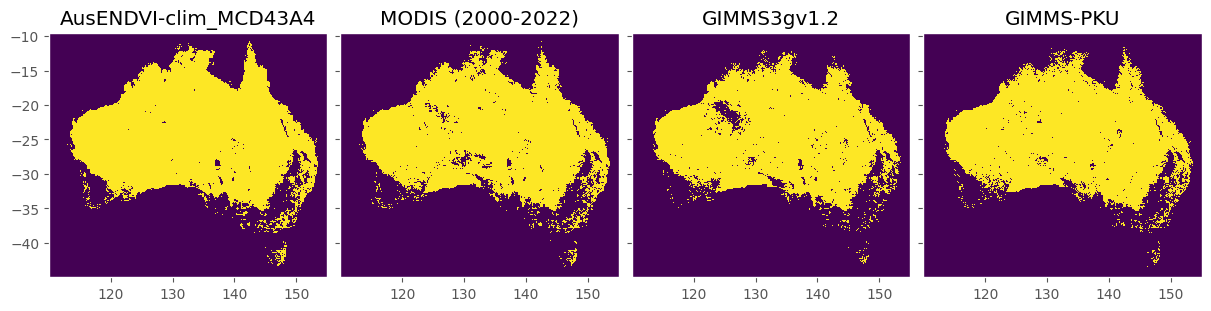

In [8]:
fig,ax=plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True, layout='constrained')
wl_mask_ds.plot(ax=ax[0], add_colorbar=False, add_labels=False)
wl_mask_modis.plot(ax=ax[1], add_colorbar=False, add_labels=False)
wl_mask_gimmsv2.plot(ax=ax[2], add_colorbar=False, add_labels=False)
wl_mask_pku.plot(ax=ax[3], add_colorbar=False, add_labels=False)

ax[0].set_title('AusENDVI-clim_MCD43A4')
ax[1].set_title('MODIS (2000-2022)')
ax[2].set_title('GIMMS3gv1.2')
ax[3].set_title('GIMMS-PKU');


#### Take the intersection of all masks from each product

That way we have the same extent for each product.

In [9]:
wl_mask_combined = (wl_mask_ds & wl_mask_gimmsv2 & wl_mask_pku)

### Alternative: Simple masking of bioclim regions

In [10]:
# gdf = gpd.read_file('/g/data/os22/chad_tmp/AusENDVI/data/bioclimatic_regions.geojson')
# gdf = gdf[gdf['region_name'].isin(['Savanna','Desert'])]
# wl_mask_combined = xr_rasterize(gdf, ag)
# wl_mask_combined = round_coords(wl_mask_combined)

### Apply water-limited mask

In [11]:
ds = ds.where(wl_mask_combined)
gimmsv2 = gimmsv2.where(wl_mask_combined)
pku = pku.where(wl_mask_combined)
rain = rain.where(wl_mask_combined)

## Map of analysis region

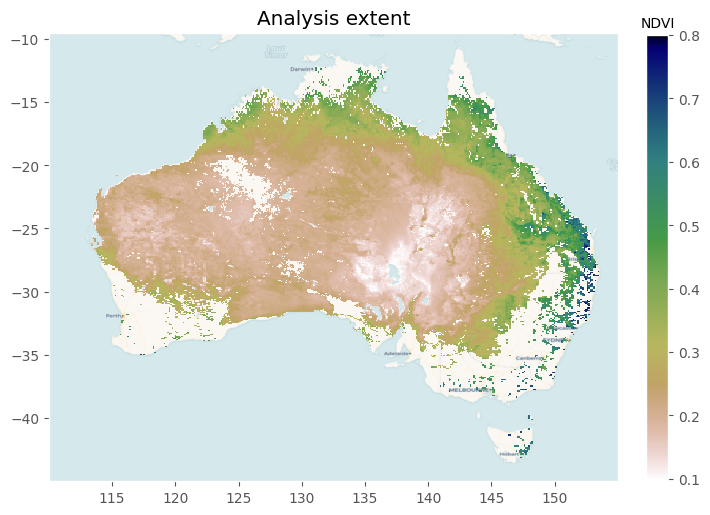

In [12]:
fig,ax=plt.subplots(1,1, figsize=(7,6), sharey=True, sharex=True, layout='constrained')
im= ds.mean('time').plot(ax=ax,cmap='gist_earth_r', vmin=0.1, vmax=0.8, add_colorbar=False, add_labels=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
cbar = plt.colorbar(im, shrink=0.75, orientation='vertical')
cbar.ax.set_title('NDVI', fontsize=10)
ax.set_title('Analysis extent');

## Map precipitation bins to NDVI

### Function for calculating Fx

Rolling five-year means of annual mean NDVI and annual sum of rainfall

In [13]:
def fx_slopes(ndvi_ds, rain_ds, thres):

    #annual datasets with five year rolling means.
    ndvi_annual = ndvi_ds.groupby('time.year').mean('time')
    rain_annual = rain_ds.groupby('time.year').sum('time')
    
    ndvi_annual = ndvi_annual.rolling(year=5, min_periods=5).mean()
    rain_annual = rain_annual.rolling(year=5, min_periods=5).mean()

    #remask rain to remove 0 values from summing.
    rain_annual = rain_annual.where(wl_mask_combined)
    
    # ----Extract 95th percentile NDVI of rainfall bins --------
    bins=np.arange(60,1300, step=20) #bins every 20mm (lowest 5yr mean is 70mm)
    years = range(1986,2023) #years after removing first 5 years.
    Fx_edge = {}

    # Loop through each year and find Fx edge.
    for year in years: 
        x = ndvi_annual.sel(year=year)
        y = rain_annual.sel(year=year)
        
        q_for_bin = []
        for b in bins:
            # Create spatial mask where rainfall is within bin range 
            rain_mask = xr.where((y<=b) & (y>b-20), 1, 0)
            # apply mask to find NDVI values and then
            # take 95th percentile value
            q = x.where(rain_mask).quantile([0.95])
            q_for_bin.append(q.data[0])
    
        Fx_edge[str(year)]=q_for_bin

    #place Fx values into nice dataframe
    df = pd.DataFrame(Fx_edge, index=bins)
  
    # ---------Break point regression-------------------------
    brk_pts_rain = []
    brk_pts_ndvi = []
    slopes = []
    intercept = []

    #loop through years
    for year in years:
        #grab out Fx values and rainfall bin values
        y = df[str(year)].values
        x = df[str(year)].index.values
        
        #threshold method, where NDVI>threshold
        ndvi_edge_idx = np.argmax(y>thres)
    
        # #find rainfall value at ndvi edge
        bp_idx = df[str(year)].iloc[[ndvi_edge_idx]].index.values.item()
        brk_pts_rain.append(bp_idx)        

        # Slope between 0 and break-point, simple least-squares linear
        # first need to ensure there are no NaNs
        xx = df.index[df.index<=bp_idx].values
        yy = y[df.index<=bp_idx]
        idx=np.isfinite(yy)
        yy = yy[idx]
        xx=xx[idx]
    
        assert len(xx)==len(yy) #check before regression
        s, i, r, p, se = stats.linregress(x=xx, y=yy)
        
        slopes.append(s)
        intercept.append(i)

    brk_pts = pd.DataFrame(data=brk_pts_rain, index=years).reset_index()
    brk_pts = brk_pts.rename({0:'Rainfall breakpoint', 'index':'year'},axis=1)
    brk_pts['NDVI']=thres

    slopes = pd.DataFrame(data=slopes, index=years).reset_index()
    slopes = slopes.rename({0:'slopes', 'index':'year'},axis=1)

    intercept = pd.DataFrame(data=intercept, index=years).reset_index()
    intercept = intercept.rename({0:'intercept', 'index':'year'},axis=1)

    #return all three dataframes.
    return brk_pts, slopes, intercept, df

### Define parameters for breakpoint analysis

Thresholds are slightly different for GIMMS vs AusE as long-term mean NDVI is slightly higher for GIMMS based products

In [28]:
threshold = 0.525 #0.6
gimms_threshold = 0.55 #0.6 0.55

### Apply method

In [29]:
brk_pts_ause, slopes_ause, intercept_ause, df_ause = fx_slopes(ds, rain, thres=threshold)
brk_pts_gimmsv2, slopes_gimmsv2, intercept_gimmsv2, df_gimmsv2 = fx_slopes(gimmsv2, rain, thres=gimms_threshold)
brk_pts_pku, slopes_pku, intercept_pku, df_pku = fx_slopes(pku, rain, thres=gimms_threshold)

#multiply the slopes for neatness
slopes_ause['slopes'] = slopes_ause['slopes']*1000
slopes_gimmsv2['slopes'] = slopes_gimmsv2['slopes']*1000
slopes_pku['slopes'] = slopes_pku['slopes']*1000

### Plot results for all years

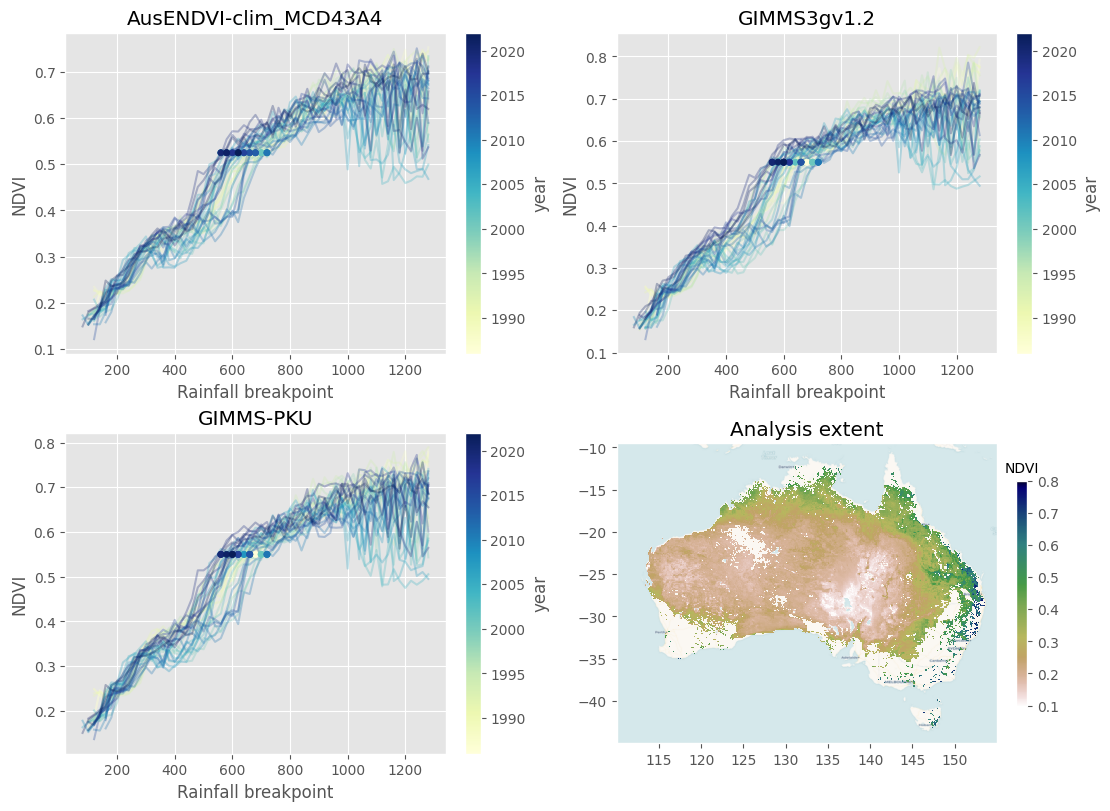

In [30]:
fig,ax=plt.subplots(2,2, figsize=(11,8), layout='constrained')

df_ause.plot(cmap='YlGnBu', legend=False, ax=ax[0,0], alpha=0.3, xlabel=None)
brk_pts_ause.plot(x='Rainfall breakpoint',  y='NDVI', ax=ax[0,0], kind='scatter', c='year', alpha=1,
             cmap='YlGnBu', zorder=10, colorbar=True, xlabel=None)
ax[0,0].set_title('AusENDVI-clim_MCD43A4')

df_gimmsv2.plot(cmap='YlGnBu', legend=False, ax=ax[0,1], alpha=0.3)
brk_pts_gimmsv2.plot(x='Rainfall breakpoint',  y='NDVI', ax=ax[0,1], kind='scatter', c='year', alpha=1,
             cmap='YlGnBu', zorder=10, ylabel=None)
ax[0,1].set_title('GIMMS3gv1.2')

df_pku.plot(cmap='YlGnBu', legend=False, ax=ax[1,0], alpha=0.3, ylabel=None)
brk_pts_pku.plot(x='Rainfall breakpoint',  y='NDVI', ax=ax[1,0], kind='scatter', c='year', alpha=1,
             cmap='YlGnBu', zorder=10, ylabel=None)
ax[1,0].set_title('GIMMS-PKU');

im= ds.mean('time').plot( ax=ax[1,1] ,cmap='gist_earth_r', vmin=0.1, vmax=0.8, add_colorbar=False, add_labels=False)
ctx.add_basemap(ax[1,1], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
cbar = plt.colorbar(im, shrink=0.70, orientation='vertical')
cbar.ax.set_title('NDVI', fontsize=10)
ax[1,1].set_title('Analysis extent');

## Plot trends

### Slopes of maximum attainable NDVI

In [31]:
c_map = plt.cm.get_cmap('magma')
arr=np.linspace(0,1,len(slopes_ause))
colorlist=list()
for c in arr:
    rgba=c_map(c)
    clr=colors.rgb2hex(rgba)
    colorlist.append(str(clr))

def Fx_slopes_plot(slopes, intercepts, x_vals, ax, colors):
    for row, c in zip(slopes.iterrows(), colors):
        y_vals = intercepts.iloc[row[0]].intercept + row[1].slopes * x_vals
        ax.plot(x_vals, y_vals, c=c)

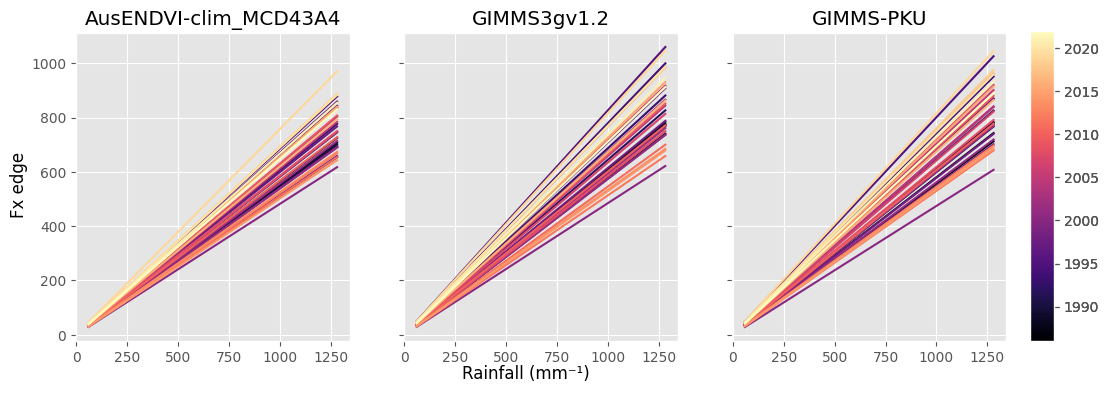

In [32]:
fig,axes=plt.subplots(1,3, figsize=(12,4), sharey=True)

ss =[slopes_ause, slopes_gimmsv2, slopes_pku]
ii = [intercept_ause, intercept_gimmsv2, intercept_pku]
dff = [df_ause, df_gimmsv2, df_pku]
names=['AusENDVI-clim_MCD43A4', 'GIMMS3gv1.2', 'GIMMS-PKU']

for s,i,d,n,ax in zip(ss, ii, dff, names, axes.ravel()):
    Fx_slopes_plot(s, i, d.index.values, ax=ax, colors=colorlist)
    ax.set_title(n)
    ax1 = fig.add_axes([0.92, 0.11, 0.020, 0.775])
    cmap = mpl.cm.magma
    norm = mpl.colors.Normalize(vmin=1986, vmax=2022)
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')

fig.supylabel('Fx edge',x=0.07, y=0.5)
fig.supxlabel('Rainfall (mm⁻¹)', x=0.5,y=0.005);

### Timeseries of slope

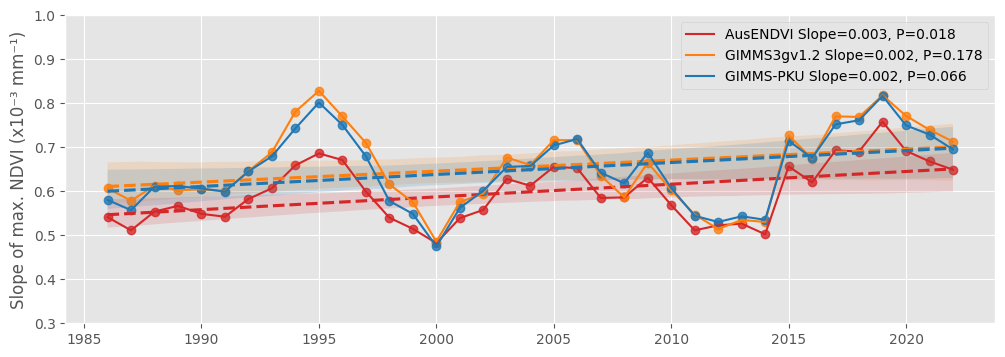

In [33]:
fig,ax = plt.subplots(1,1, figsize=(12,4))

trend = mk.original_test(slopes_ause['slopes'].values)
s,p = trend.slope, trend.p

sb.lineplot(data=slopes_ause, x="year", y="slopes", ax=ax, color='tab:red', label=f'AusENDVI Slope={s:.3f}, P={p:.3f}')
sb.regplot(x="year", y="slopes", data=slopes_ause, ax=ax, color='tab:red', line_kws={'linestyle':'--'}, robust=True);

trend = mk.original_test(slopes_gimmsv2['slopes'].values)
s,p = trend.slope, trend.p

sb.lineplot(data=slopes_gimmsv2, x="year", y="slopes", ax=ax, color='tab:orange', label=f'GIMMS3gv1.2 Slope={s:.3f}, P={p:.3f}')
sb.regplot(x="year", y="slopes", data=slopes_gimmsv2, ax=ax, color='tab:orange',line_kws={'linestyle':'--'}, robust=True);

trend = mk.original_test(slopes_pku['slopes'].values)
s,p = trend.slope, trend.p

s, i, r, p, se = stats.linregress(slopes_pku['year'].values,slopes_pku['slopes'].values)
sb.lineplot(data=slopes_pku, x="year", y="slopes", ax=ax, color='tab:blue', label=f'GIMMS-PKU Slope={s:.3f}, P={p:.3f}')
sb.regplot(x="year", y="slopes", data=slopes_pku, ax=ax, color='tab:blue',line_kws={'linestyle':'--'}, robust=True);

ax.set_title(None);
ax.set_ylabel('Slope of max. NDVI (x10'+'\u207B'+ '\u00B3'+' mm⁻¹)')
ax.set_xlabel(None)
ax.set_ylim(0.3,1.0);

### Timeseries of rainfall breakpoint

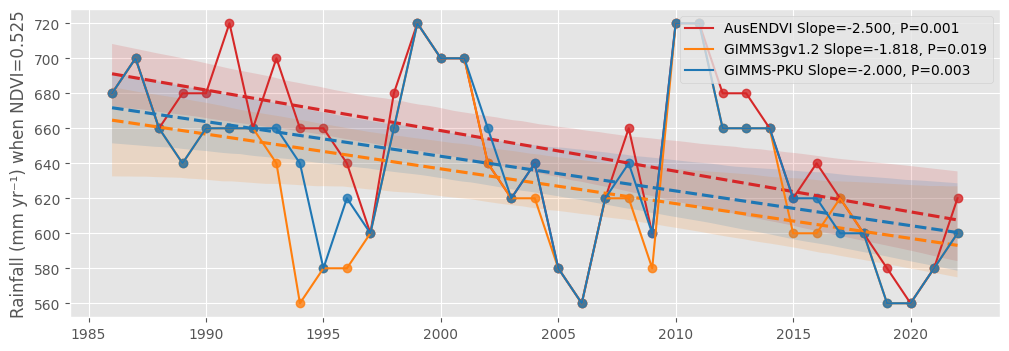

In [34]:
fig,ax=plt.subplots(1,1, figsize=(12,4))

##-----AusE----------
trend = mk.original_test(brk_pts_ause["Rainfall breakpoint"].values)
s,p = trend.slope, trend.p

sb.lineplot(data=brk_pts_ause, x="year", y="Rainfall breakpoint", ax=ax, color='tab:red', label=f'AusENDVI Slope={s:.3f}, P={p:.3f}')
sb.regplot(x="year", y="Rainfall breakpoint", data=brk_pts_ause, ax=ax,color='tab:red',line_kws={'linestyle':'--'}, robust=True)

##-----GIMMS----------
trend = mk.original_test(brk_pts_gimmsv2["Rainfall breakpoint"].values)
s,p = trend.slope, trend.p

sb.lineplot(data=brk_pts_gimmsv2, x="year", y="Rainfall breakpoint", ax=ax, color='tab:orange', label=f'GIMMS3gv1.2 Slope={s:.3f}, P={p:.3f}')
sb.regplot(x="year", y="Rainfall breakpoint", data=brk_pts_gimmsv2, ax=ax,color='tab:orange',line_kws={'linestyle':'--'}, robust=True)

##-----PKU----------
trend = mk.original_test(brk_pts_pku["Rainfall breakpoint"].values)
s,p = trend.slope, trend.p

sb.lineplot(data=brk_pts_pku, x="year", y="Rainfall breakpoint", ax=ax, color='tab:blue', label=f'GIMMS-PKU Slope={s:.3f}, P={p:.3f}')
sb.regplot(x="year", y="Rainfall breakpoint", data=brk_pts_pku, ax=ax,color='tab:blue', line_kws={'linestyle':'--'}, robust=True)

# ax.set_ylim(450,800)
ax.set_xlabel(None)
ax.set_ylabel(f'Rainfall (mm yr⁻¹) when NDVI={threshold}');

## Plot data for a single year

for testing and understanding method

In [35]:
from scipy.stats import gaussian_kde

In [36]:
ndvi_annual = ds.groupby('time.year').mean('time')
ndvi_annual = ndvi_annual.where(ndvi_annual>0) 
rain_annual = rain.groupby('time.year').sum('time')
rain_annual = rain_annual.where(ndvi_annual>0)

ndvi_annual = ndvi_annual.rolling(year=5, min_periods=5).mean()
rain_annual = rain_annual.rolling(year=5, min_periods=5).mean()

#remask rain to remove 0 values from summing.
rain_annual = rain_annual.where(wl_mask_combined)


In [37]:
bins=np.arange(60,1300, step=20)
years = range(1986,2023)
Fx_edge = {}

for year in years:
    x = ndvi_annual.sel(year=year)
    y = rain_annual.sel(year=year)
    
    q_for_bin = []
    for b in bins:
        mask = xr.where((y<=b) & (y>b-20), 1, 0)
        q = x.where(mask).quantile([0.95])
        q_for_bin.append(q.data[0])

    Fx_edge[str(year)]=q_for_bin

df = pd.DataFrame(Fx_edge, index=bins)    

In [38]:
# ---------Break point regression-------------------------
brk_pts_rain = []
brk_pts_ndvi = []
slopes = []
intercept = []

#loop through years
for year in years:
    #grab out Fx values and rainfall bin values
    y = df[str(year)].values
    x = df[str(year)].index.values
    
    #threshold method, where NDVI>threshold
    ndvi_edge_idx = np.argmax(y>0.525)

    # find rainfall value at ndvi edge
    bp_idx = df[str(year)].iloc[[ndvi_edge_idx]].index.values.item()
    brk_pts_rain.append(bp_idx)        

    # Slope between 0 and break-point, simple least-squares linear
    xx = df.index[df.index<=bp_idx].values
    yy = y[df.index<=bp_idx]
    idx=np.isfinite(yy) #remove any NaNs
    yy = yy[idx]
    xx=xx[idx]

    assert len(xx)==len(yy)
    
    s, i, r, p, se = stats.linregress(x=xx, y=yy)
    slopes.append(s)
    intercept.append(i)

brk_pts = pd.DataFrame(data=brk_pts_rain, index=years).reset_index()
brk_pts = brk_pts.rename({0:'Rainfall breakpoint', 'index':'year'},axis=1)
brk_pts['NDVI']=0.525

slopes = pd.DataFrame(data=slopes, index=years).reset_index()
slopes = slopes.rename({0:'slopes', 'index':'year'},axis=1)

intercept = pd.DataFrame(data=intercept, index=years).reset_index()
intercept = intercept.rename({0:'intercept', 'index':'year'},axis=1)

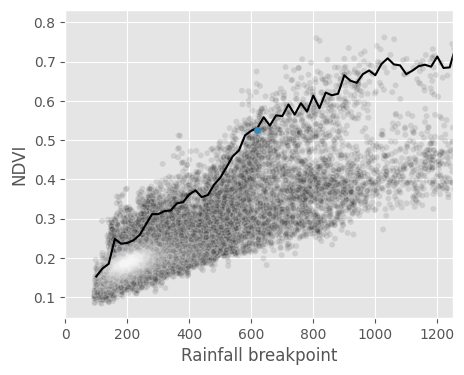

In [39]:
year = 2022
plot_df = rain_annual.sel(year=year).drop('spatial_ref').to_dataframe(name='rain').drop('year', axis=1).reset_index(drop=True)
plot_df['ndvi'] = ndvi_annual.sel(year=year).drop('spatial_ref').to_dataframe(name='NDVI').drop('year', axis=1).reset_index(drop=True)
plot_df=plot_df.dropna()
plot_df = plot_df.sample(25000)

fig,ax=plt.subplots(1,1, figsize=(5,4))

brk_pts[brk_pts['year']==year].plot(x='Rainfall breakpoint',  y='NDVI', ax=ax, kind='scatter', alpha=1,
             cmap='YlGnBu', zorder=10, xlabel=None)

obs, pred = plot_df['rain'].values, plot_df['ndvi'].values
xy = np.vstack([obs,pred])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=plot_df, x='rain',y='ndvi', c=z, s=20, lw=1, alpha=0.1, ax=ax, cmap='Greys_r')
df[str(year)].plot(cmap='inferno', ax=ax, legend=False);
ax.set_xlim(0,1250);


In [26]:
# pw_fit = piecewise_regression.Fit(df_ause['1986'].index.values, df_ause['1986'].values, n_breakpoints=1)
# pw_fit.plot_data(color="grey", s=20)
# # Pass in standard matplotlib keywords to control any of the plots
# pw_fit.plot_fit(color="red", linewidth=4)
# pw_fit.plot_breakpoints()
# pw_fit.plot_breakpoint_confidence_intervals()

In [27]:
        # # ------------------------------------
        # # Tried using several methods for automated breakpoint analysis
        # # but they are all too inconsistent to reliable
        # if method == 'piecewise_regression':
        #     pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=1)
        #     results = pw_fit.get_results()
        #     bp_idx = results['estimates']['breakpoint1']['estimate']
        #     brk_pts_rain.append(bp_idx)
            
        #     #find NDVI values at BP of rain
        #     bp_ndvi_idx = np.argmin(np.abs(x - bp_idx))
        #     brk_pts_ndvi.append(y[bp_ndvi_idx])
         
        # if method == 'jenkspy':   
        #     bp = jenkspy.jenks_breaks(y, n_classes=2)
        #     bp = bp[1]
        #     brk_pts_ndvi.append(bp)
            
        #     # find rainfall value at BP
        #     bp_idx = df[str(year)][df[str(year)]==bp].index[0]
        #     brk_pts_rain.append(bp_idx)
    
# #create dataframes for results, slighty different depeneding on method.
#     if method != 'threshold':
#         brk_pts = pd.DataFrame(data=brk_pts_ndvi, index=brk_pts_rain).reset_index()
#         brk_pts = brk_pts.rename({0:'NDVI', 'index':'Rainfall breakpoint'},axis=1)
#         brk_pts['year'] = years
